### Import modules and packages. define functions

In [435]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns

from pyspark import SparkContext, SparkConf


%matplotlib inline

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

### Specify experiment directory, condtions and image details
#### Makes dictionary for later storage of results

In [628]:
expdir='/Users/taldankovich/Documents/BicTurnover_180130/' #master folder

early_channel_no=2 #channel number of early incubation colour
late_channel_no=1 #channel number of late incubation colour

results = {"filename":[],
           "Early colour - spots mask":[],
           "Late colour - spots mask":[],
           "exp condition":[],
           "Early colour - Raw mean intensity":[],
           "Late colour - Raw mean intensity":[],
           "Mean correlation coefficient early/late":[],
           "Early colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Late colour - Mean intensity of spots":[], #based on spot segmentation mask
           "Early colour - Total no. of spots in FOV":[],
           "Late colour - Total no. of spots in FOV":[],
           "Early colour - Mean spot area [nm]":[],
           "Late colour - Mean spot area [nm]":[],
           "Mean colour bias of a pixel (early=-1<x<1=late)":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))
        
for i in range(0,len(filelist)):
    if filelist[i].endswith(".nd2") & ("60x" in str(filelist[i]))==True:
        results["filename"].append(filelist[i])
        results["exp condition"].append(filelist[i].split('/')[-2])

### Find the spots: Segmentation masked made by adaptive thresholding followed by binary morphology
#### Play with sigma gauss and i (struct shape) to optimize first

/Users/taldankovich/Documents/BicTurnover_180130/1Day/08_60x_002.nd2


/Users/taldankovich/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


/Users/taldankovich/Documents/BicTurnover_180130/Fixedctrl_early_immediately_late/02_60x_011.nd2
/Users/taldankovich/Documents/BicTurnover_180130/1Day/06_01_60x_008.nd2
/Users/taldankovich/Documents/BicTurnover_180130/Fixedctrl_early_backininc_1day/03_1_60x_007.nd2
/Users/taldankovich/Documents/BicTurnover_180130/Fixedctrl_early_backininc_1day/03_1_60x_007.nd2


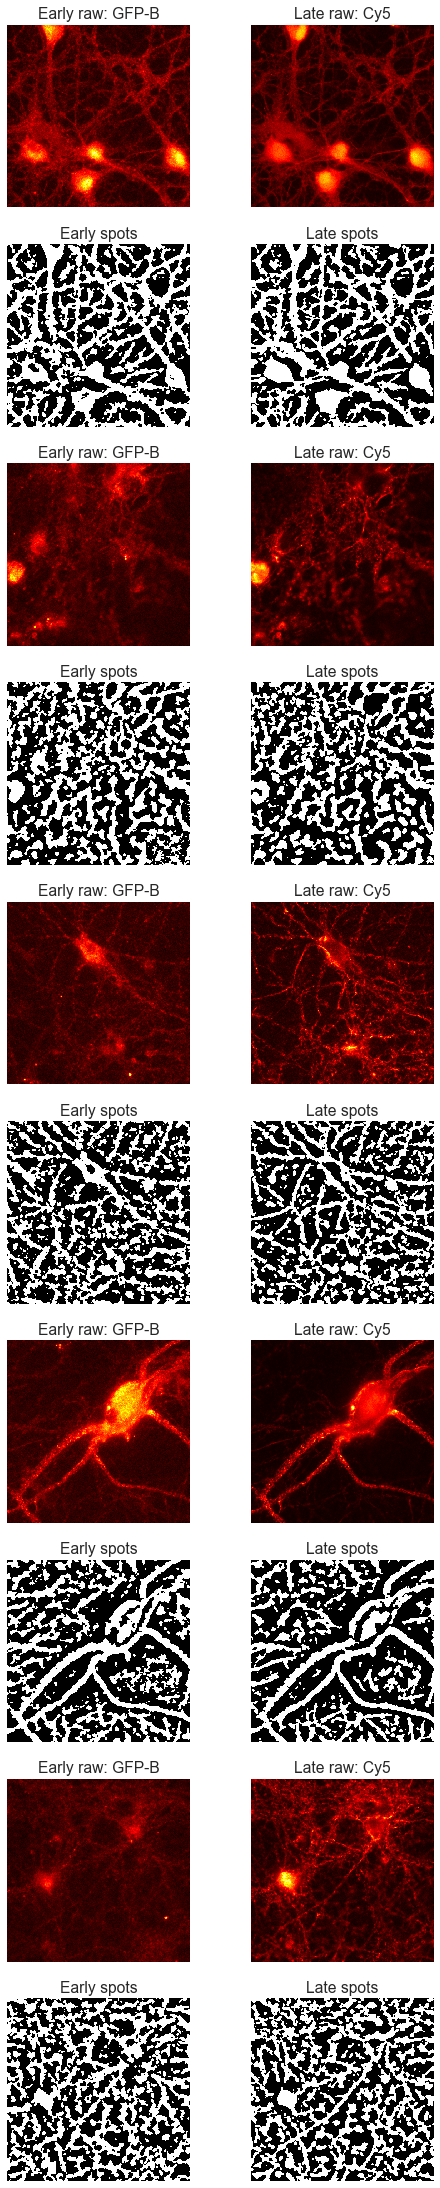

In [624]:
fig=plt.figure(figsize=(8,80))
figno=1
for im in range(0,5):
    with ND2Reader(results["filename"][np.random.randint(1,len(results["filename"]))]) as images:
        print(results["filename"][np.random.randint(1,len(results["filename"]))])
        early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        [channel1name, channel2name]=early_image.metadata['channels']
        if early_channel_no==2:
            early_channelname=channel2name
            late_channelname=channel1name
        else:
            early_channelname=channel1name
            late_channelname=channel2name

        #smoothing with gaussian filter for noise reduction
        #can play with sigma
        sigmagauss=2
        early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
        late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)

        #adaptive thresholding - bg found by mean filter with SE
        i=51 #for SE
        struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2
        bg_early = rank.mean(early_smooth, selem=struct)
        bg_late = rank.mean(late_smooth, selem=struct)
        early_spots = early_smooth >= bg_early
        late_spots = late_smooth >= bg_late
        #improve with binary hole filling
        #early_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(early_spots))
        #late_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(late_spots))
        #improve with binary closing
        #i2 = 3
        #struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
        #pad_size = i+2 #pad the spots image to avoid artifacts at the edges
        #padded_early_spots = np.pad(early_spots_holes_filled,pad_size,mode='reflect')
        #padded_late_spots = np.pad(late_spots_holes_filled,pad_size,mode='reflect')
        #early_spots_final = ndi.binary_closing(np.logical_not(padded_early_spots),structure=struct2)
        #late_spots_final = ndi.binary_closing(np.logical_not(padded_late_spots),structure=struct2)
        #remove the padding from before
        #early_spots_final = early_spots_final[pad_size:-pad_size,pad_size:-pad_size]
        #late_spots_final = late_spots_final[pad_size:-pad_size,pad_size:-pad_size]
            
        fig.add_subplot(20,2,figno)
        plt.imshow(early_image,interpolation='none',cmap='hot')
        plt.title('Early raw: '+early_channelname)
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.add_subplot(20,2,figno+1)
        plt.imshow(late_image,interpolation='none',cmap='hot')
        plt.title('Late raw: '+late_channelname)
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.add_subplot(20,2,figno+2)
        plt.imshow(early_spots,interpolation='none',cmap='gray')
        plt.title('Early spots')
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        fig.add_subplot(20,2,figno+3)
        plt.imshow(late_spots,interpolation='none',cmap='gray')
        plt.title('Late spots')
        ax=plt.gca()
        ax.grid(color='none')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        figno=figno+4

#### After optimizing, run below to make segmentation masks for all images

In [629]:
for im in range(0,len(results["filename"])): 
    with ND2Reader(results["filename"][im]) as images:
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            
            #smoothing with gaussian filter for noise reduction
            #can play with sigma
            # sigmagauss=3 #taken from previous cell
            early_smooth = ndi.filters.gaussian_filter(early_image,sigmagauss)
            late_smooth = ndi.filters.gaussian_filter(late_image,sigmagauss)
            early_image=np.divide(early_image,16383.)
            late_image=np.divide(late_image,16383.)
            
            #adaptive thresholding - bg found by mean filter with SE
            #i=31 #for SE - taken from previous cell
            struct = (np.mgrid[:i,:i][0] - np.floor(i/2))**2 + (np.mgrid[:i,:i][1] - np.floor(i/2))**2 <= np.floor(i/2)**2
            bg_early = rank.mean(early_smooth, selem=struct)
            bg_late = rank.mean(late_smooth, selem=struct)
            early_spots = early_smooth >= bg_early
            late_spots = late_smooth >= bg_late
            #improve with binary hole filling
            #early_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(early_spots))
            #late_spots_holes_filled = ndi.binary_fill_holes(np.logical_not(late_spots))
            #improve with binary closing
            #i2 = 3
            #struct2 = (np.mgrid[:i2,:i2][0] - np.floor(i2/2))**2 + (np.mgrid[:i2,:i2][1] - np.floor(i2/2))**2 <= np.floor(i2/2)**2
            #pad_size = i+2 #pad the spots image to avoid artifacts at the edges
            #padded_early_spots = np.pad(early_spots_holes_filled,pad_size,mode='reflect')
            #padded_late_spots = np.pad(late_spots_holes_filled,pad_size,mode='reflect')
            #early_spots_final = ndi.binary_closing(np.logical_not(padded_early_spots),structure=struct2)
            #late_spots_final = ndi.binary_closing(np.logical_not(padded_late_spots),structure=struct2)
            #remove the padding from before
            #early_spots_final = early_spots_final[pad_size:-pad_size,pad_size:-pad_size]
            #late_spots_final = late_spots_final[pad_size:-pad_size,pad_size:-pad_size]
            
            results["Early colour - spots mask"].append(early_spots)
            results["Late colour - spots mask"].append(late_spots)

/Users/taldankovich/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)
/Users/taldankovich/anaconda/lib/python3.6/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 13 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


In [630]:
#calculate the mean autofluorescence in each channel for later subtraction
lookuplist=[('filename',results["filename"]),('exp condition',results["exp condition"])] 
lookupdf = pd.DataFrame.from_items(lookuplist)
#no_images=len(lookupdf[lookupdf["exp condition"]=="fixedctrl_nocolours"])

earlybg_filelist=lookupdf[lookupdf["exp condition"]=="fixedctrl_nocolours_from180214"]
latebg_filelist=lookupdf[lookupdf["exp condition"]=="fixedctrl_nocolours_from180214"]


no_images_earlybg=len(lookupdf[lookupdf["exp condition"]=="fixedctrl_nocolours_from180214"])
no_images_latebg=len(lookupdf[lookupdf["exp condition"]=="fixedctrl_nocolours_from180214"])

                      
earlycolour_autoint=np.zeros((no_images_earlybg,1))
latecolour_autoint=np.zeros((no_images_latebg,1))

for i in range(0,no_images_earlybg):
    with ND2Reader(earlybg_filelist.iloc[i]["filename"]) as images:
        early_image=images[early_channel_no-1]
        #late_image=images[late_channel_no-1]
        #medfilt 
        early_image=ndi.filters.median_filter(early_image,size=(3,3))
        earlycolour_autoint[i]=np.mean(early_image)
for i in range(0,no_images_latebg):
    with ND2Reader(latebg_filelist.iloc[i]["filename"]) as images:
        #early_image=images[early_channel_no-1]
        late_image=images[late_channel_no-1]
        #medfilt 
        late_image=ndi.filters.median_filter(late_image,size=(3,3))
        latecolour_autoint[i]=np.mean(late_image)
        
early_autoint_mean=np.mean(earlycolour_autoint)
late_autoint_mean=np.mean(latecolour_autoint)

print(early_autoint_mean)
print(late_autoint_mean)

396.52792892456057
153.2500202178955


In [617]:
print(no_images_latebg)

10


In [548]:
#if no controls done - run this
early_autoint_mean=0
late_autoint_mean=0

### Batch analyse images, after creating the segmentation masks

In [631]:
for i in range(0,len(results["filename"])): 
    with ND2Reader(results["filename"][i]) as images:
            #read the images
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            #medfilt 
            early_image=ndi.filters.median_filter(early_image,size=(3,3))
            late_image=ndi.filters.median_filter(late_image,size=(3,3))
            #convert to array
            early_image=early_image.astype(np.int16)
            late_image=late_image.astype(np.int16)
            #subtract autofluorescence in each channel
            early_image=early_image-early_autoint_mean
            early_image[early_image<0]=0
            late_image=late_image-late_autoint_mean
            late_image[late_image<0]=0
            #normalize intensity to value between 0 and 1
            early_image=np.divide(early_image,16383.)
            late_image=np.divide(late_image,16383.)
            #read spots masks
            early_spots=results["Early colour - spots mask"][i]
            late_spots=results["Late colour - spots mask"][i]
            #label the spots
            spots_early_labels,_ = ndi.label(early_spots)
            spots_late_labels,_ = ndi.label(late_spots)
            #calculate results
            early_spots_intensities=np.zeros((len(np.unique(spots_early_labels)),1))
            early_spots_areas=np.zeros((len(np.unique(spots_early_labels)),1))
            late_spots_intensities=np.zeros((len(np.unique(spots_late_labels)),1))
            late_spots_areas=np.zeros((len(np.unique(spots_late_labels)),1))
            spots_late_minus_early_int=np.zeros((len(np.unique(spots_early_labels)),1))
            
            for spotno in np.unique(spots_early_labels)[1:]:
                early_spots_mask = spots_early_labels==spotno
                early_spots_intensities[(spotno)]=np.mean(early_image[early_spots_mask])
                early_spots_areas[spotno]=np.sum(early_spots_mask)
                
                a=late_image[early_spots_mask]
                b=early_image[early_spots_mask]
                spots_late_minus_early_int[spotno]=np.mean(np.divide([a-b],[a+b]))
                    
            for spotnol in np.unique(spots_late_labels)[1:]:
                late_spots_mask= spots_late_labels==spotnol
                late_spots_intensities[spotnol]=np.mean(late_image[late_spots_mask])
                late_spots_areas[spotnol]=np.sum(late_spots_mask)
            
            #result calculation:
            
            #results based on spot segmentation    
            results["Early colour - Mean intensity of spots"].append(np.mean(early_spots_intensities))
            results["Late colour - Mean intensity of spots"].append(np.mean(late_spots_intensities))
            results["Early colour - Total no. of spots in FOV"].append(len(early_spots_intensities))
            results["Late colour - Total no. of spots in FOV"].append(len(late_spots_intensities))
            results["Early colour - Mean spot area [nm]"].append(np.mean(early_spots_areas))
            results["Late colour - Mean spot area [nm]"].append(np.mean(late_spots_areas))
            #global results
            results["Early colour - Raw mean intensity"].append(np.mean(early_image))
            results["Late colour - Raw mean intensity"].append(np.mean(late_image))
            results["Mean correlation coefficient early/late"].append(corr2(early_image,late_image))
            
            #a=np.array(late_image, dtype=float)
            #b=np.array(early_image,dtype=float)
            #c=np.divide([a-b],[a+b])
            results["Mean colour bias of a pixel (early=-1<x<1=late)"].append(np.mean(spots_late_minus_early_int))
            

/Users/taldankovich/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide


### Make a clean figure of an experimental condition, with merged image and scalebar

In [52]:
experimental_condition_to_display='1 day' #'1 day' or '1 day + bic'

medfiltarray=[3,3] #play with med filter size

fig=plt.figure(figsize=(10,100))
no_of_ims_in_condition = sum( x == experimental_condition_to_display for x in results["exp condition"] )
print(no_of_ims_in_condition)
counter=1

for i in range(0,len(results["filename"])): 
    if (results["exp condition"][i]==experimental_condition_to_display and counter<15):
        
        with ND2Reader(results["filename"][i]) as images:
            early_image=images[early_channel_no-1]
            late_image=images[late_channel_no-1]
            
            #some basic preprocessing: smoothing (noise reduction) with med filter, and contrast adjustment
            early_smoothed=ndi.filters.median_filter(early_image,medfiltarray)
            v_min1, v_max1 = np.percentile(early_smoothed, (0.2, 99.8))
            early_smoothed_adjusted=exposure.rescale_intensity(early_smoothed, in_range=(v_min1, v_max1))
            late_smoothed=ndi.filters.median_filter(late_image,medfiltarray)
            v_min2, v_max2 = np.percentile(late_smoothed, (0.2, 99.8))
            late_smoothed_adjusted=exposure.rescale_intensity(late_smoothed, in_range=(v_min2, v_max2))
            
            #make early image green and late image red
            greencmap = clr.LinearSegmentedColormap.from_list('customred', ['#000000','#06C420'], N=256)
            redcmap=clr.LinearSegmentedColormap.from_list('customred', ['#000000','#FD0120'], N=256)

            normearly = early_smoothed_adjusted.astype(np.float32) # convert to float
            normearly -= normearly.min() # ensure the minimal value is 0.0
            normearly /= normearly.max() # maximum value in image is now 1.0
            normlate = late_smoothed_adjusted.astype(np.float32) # convert to float
            normlate -= normlate.min() # ensure the minimal value is 0.0
            normlate /= normlate.max() # maximum value in image is now 1.0
            
            early_ingreen=greencmap(normearly)
            late_inred=redcmap(normlate)
            
            #make composite with a scalebar
            comp=Image.blend(toimage(early_ingreen),toimage(late_inred),0.5)
            micronsperpixel=early_image.metadata['pixel_microns']
            scalebar = ScaleBar(dx=micronsperpixel,units='um',color='white',length_fraction=0.16,bar_color='none') # 1 pixel = 0.2 meter
            
            fig.add_subplot(no_of_ims_in_condition,3,counter)
            plt.imshow(early_ingreen,interpolation='none')
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
            plt.gca().set_aspect('equal')
            plt.gca().grid(color='none')

            fig.add_subplot(no_of_ims_in_condition,3,(counter+1))
            plt.imshow(late_inred,interpolation='none')
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
            plt.gca().set_aspect('equal')
            plt.gca().grid(color='none')
            
            fig.add_subplot(no_of_ims_in_condition,3,(counter+2))
            plt.imshow(comp)
            plt.gca().add_artist(scalebar)
            plt.gca().set_xticklabels([])
            plt.gca().set_yticklabels([])
            plt.gca().set_aspect('equal')
            plt.gca().grid(color='none')
            
            counter=counter+3
            
plt.subplots_adjust(wspace=0, hspace=0)

15


/Users/taldankovich/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


TypeError: __init__() got an unexpected keyword argument 'bar_color'

### Plots

In [632]:
df=pd.DataFrame(results)
df.to_json(path_or_buf=expdir+'results2.json')

In [421]:
df=pd.read_json(path_or_buf=expdir+'results2.json')

In [633]:
df_corrected=df

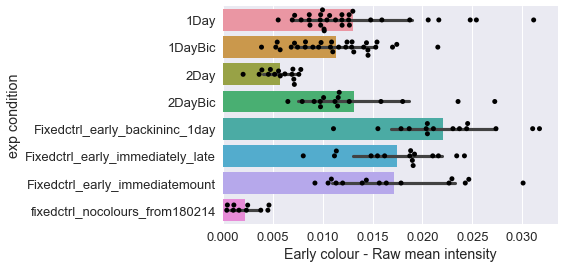

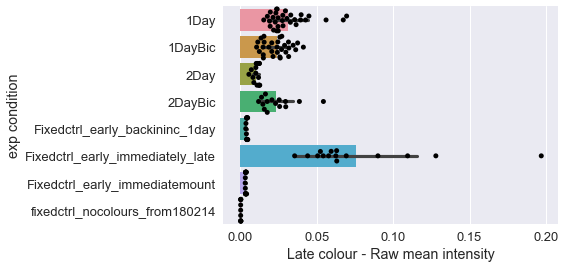

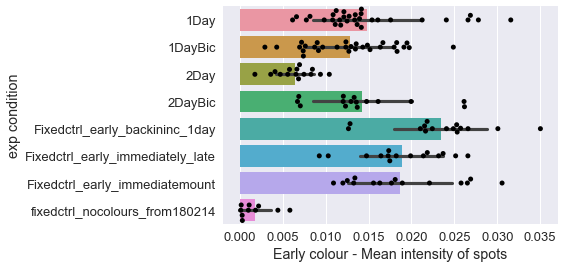

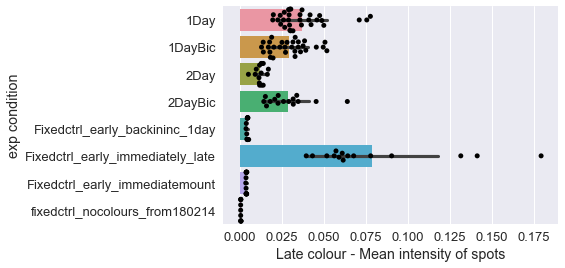

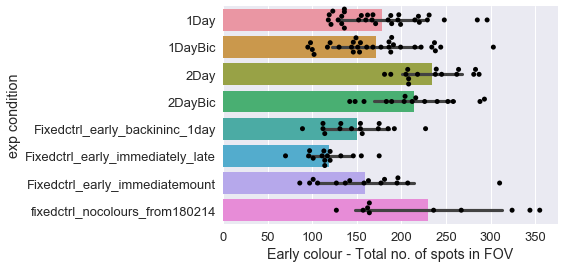

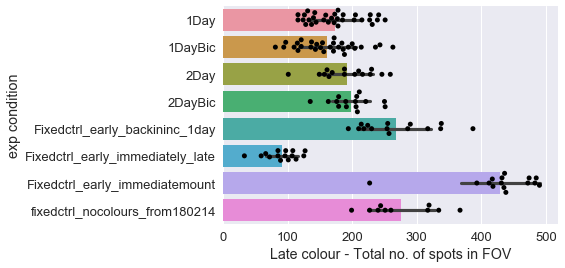

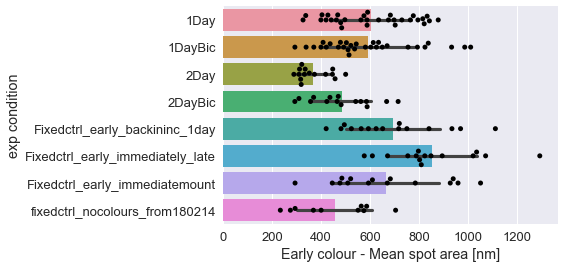

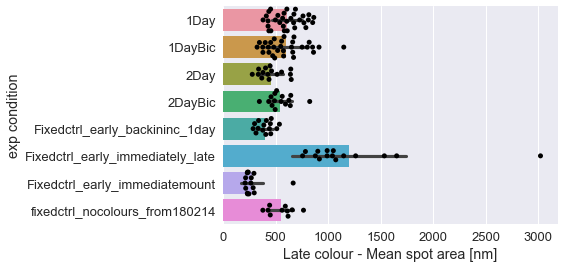

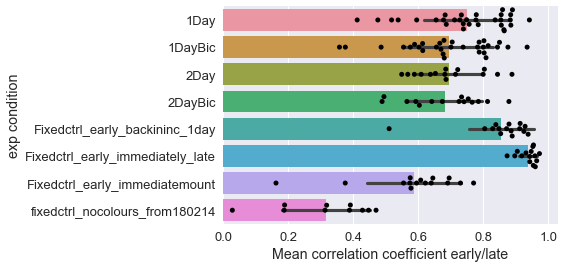

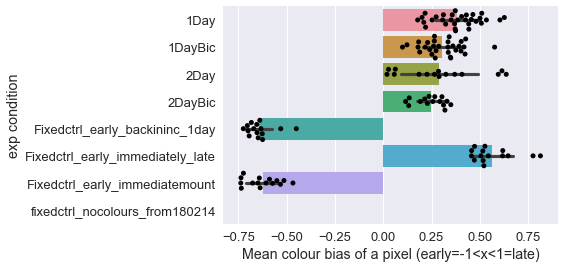

In [634]:
from matplotlib.backends.backend_pdf import PdfPages
def multipage(filename, figs=None, dpi=200):
    pp = PdfPages(filename)
    if figs is None:
        figs = [plt.figure(n) for n in plt.get_fignums()]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()
    
#sns.set_xticklabels(rotation=90)
sns.set(font_scale=1.3)


fig1=plt.figure()
d=sns.barplot(x="Early colour - Raw mean intensity", y="exp condition",data=df_corrected,ci='sd')
d=sns.swarmplot(x="Early colour - Raw mean intensity", y="exp condition",data=df_corrected,color='black')
fig1.savefig('plot1.png',bbox_inches='tight')

fig2=plt.figure()
d=sns.barplot(x='Late colour - Raw mean intensity', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Raw mean intensity", y="exp condition",data=df_corrected,color='black')
fig2.savefig('plot2.png',bbox_inches='tight')

fig3=plt.figure()
d=sns.barplot(x='Early colour - Mean intensity of spots', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour - Mean intensity of spots", y="exp condition",data=df_corrected,color='black')
fig3.savefig('plot3.png',bbox_inches='tight')

fig4=plt.figure()
d=sns.barplot(x='Late colour - Mean intensity of spots', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Mean intensity of spots", y="exp condition",data=df_corrected,color='black')
fig4.savefig('plot4.png',bbox_inches='tight')

fig5=plt.figure()
d=sns.barplot(x='Early colour - Total no. of spots in FOV', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour - Total no. of spots in FOV", y="exp condition",data=df_corrected,color='black')
fig5.savefig('plot5.png',bbox_inches='tight')

fig6=plt.figure()
d=sns.barplot(x='Late colour - Total no. of spots in FOV', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Total no. of spots in FOV", y="exp condition",data=df_corrected,color='black')
fig6.savefig('plot6.png',bbox_inches='tight')

fig7=plt.figure()
d=sns.barplot(x='Early colour - Mean spot area [nm]', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Early colour - Mean spot area [nm]", y="exp condition",data=df_corrected,color='black')
fig7.savefig('plot7.png',bbox_inches='tight')

fig8=plt.figure()
d=sns.barplot(x='Late colour - Mean spot area [nm]', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Late colour - Mean spot area [nm]", y="exp condition",data=df_corrected,color='black')
fig8.savefig('plot8.png',bbox_inches='tight')

fig9=plt.figure()
d=sns.barplot(x='Mean correlation coefficient early/late', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Mean correlation coefficient early/late", y="exp condition",data=df_corrected,color='black')
fig9.savefig('plot9.png',bbox_inches='tight')

fig10=plt.figure()
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_corrected, ci='sd')
d=sns.swarmplot(x="Mean colour bias of a pixel (early=-1<x<1=late)", y="exp condition",data=df_corrected,color='black')
fig10.savefig('plot10.png',bbox_inches='tight')




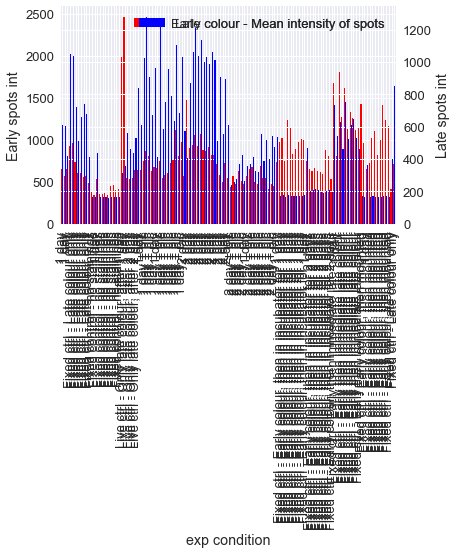

In [201]:
fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

df.plot(x='exp condition', y='Early colour - Mean intensity of spots',kind='bar', color='red', ax=ax, width=width, position=1)
df.plot(x='exp condition', y='Late colour - Mean intensity of spots',kind='bar', color='blue', ax=ax2, width=width, position=0)

ax.set_ylabel('Early spots int')
ax2.set_ylabel('Late spots int')

plt.show()






In [636]:
df_means=df.groupby('exp condition').mean()

In [638]:
df_means['Late - early spot int']=df_means['Late colour - Mean intensity of spots']


In [639]:
df_means['Late - early spot int']=df_means['Late - early spot int'].sub(df_means['Early colour - Mean intensity of spots'],axis=0)

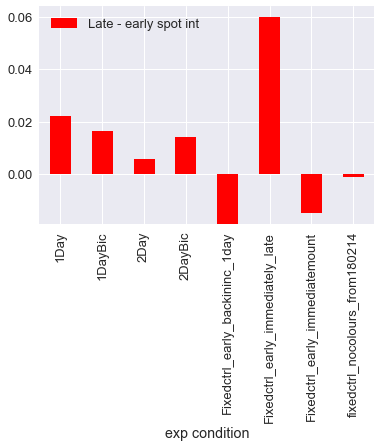

In [640]:
fig=plt.figure()
df_means.plot(y='Late - early spot int',kind='bar', color='red')



In [264]:
expdir='/Users/taldankovich/Documents/BicTurnover_180130/'
dfnew=pd.read_json(path_or_buf=expdir+'results.json')

In [562]:
results["Mean colour bias of a pixel (early=-1<x<1=late)"]

[0.7416066967919855,
 0.8182531320139536,
 0.4174304659865646,
 0.625226413878514,
 0.6505386137596443,
 0.5928711371051838,
 1.4857894178457203,
 1.7505192758982753,
 0.6508457115600443,
 0.6339093993389745,
 1.1732533164660255,
 0.7177090489209712,
 0.472291062181152,
 0.7146448030912377,
 0.5880798245839812,
 0.5396692515758266,
 1.0868513521413903,
 0.6875094482642545,
 0.3052514315874968,
 2.0332460177036182,
 0.3118919223668706,
 0.46273722927504357,
 1.3135821231811824,
 1.7708648988835534,
 2.621727068339392,
 1.7971123772334339,
 1.2143124875402098,
 0.6377541397260262,
 -0.18026408774025915,
 0.7422180759502299,
 0.09191164842059907,
 1.6858919440108455,
 1.8840828285348072,
 5.052691401322126,
 0.9716823664857915,
 1.109770334422364,
 0.7766697663180459,
 0.6671774609756413,
 2.0110466255602573,
 1.2824650128373225,
 1.4300643563467526,
 1.8195223858981273,
 2.075619847053652,
 2.8297480428311403,
 1.3440271868646325,
 1.2185531574094735,
 1.1202170004539527,
 0.317467074009

In [289]:
dfbics=df[df["exp condition"].isin(['1Day', '1DayBic','2Day', '2DayBic','3Day', '3DayBic'])]

In [290]:
fig10=plt.figure()
d=sns.barplot(x='Mean colour bias of a pixel (early=-1<x<1=late)', y='exp condition',data=df_correctedbics, ci='sd')

ValueError: min() arg is an empty sequence

In [288]:
dfbics[dfbics['exp condition']=='day 3']

,Early colour - Mean intensity of spots,Early colour - Mean spot area [nm],Early colour - Raw mean intensity,Early colour - Total no. of spots in FOV,Early colour - spots mask,Late colour - Mean intensity of spots,Late colour - Mean spot area [nm],Late colour - Raw mean intensity,Late colour - Total no. of spots in FOV,Late colour - spots mask,Mean colour bias of a pixel (early=-1<x<1=late),Mean correlation coefficient early/late,exp condition,filename
